In [3]:
import json
import os
import re
import spacy
import sys
import time
from collections import defaultdict
from pathlib import Path
from typing import Any, Dict, List

import numpy as np
import matplotlib.pyplot as plt

from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
# nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

# model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
# keybert = KeyBERT(model=model)
model = SentenceTransformer()
keybert = KeyBERT()

In [5]:
movies = {
    13: "Forrest Gump",
    120: "The Lord of the Rings: The Fellowship of the Ring",
    330: "The Lost World: Jurassic Park",
    480105: "47 Meters Down: Uncaged",
    568: "Apollo 13",
    436270: "Black Adam",
    49013: "Cars 2",
    23483: "Kick-Ass",
    268896: "Pacific Rim: Uprising",
    676: "Pearl Harbor"
}


all_users = None
with open("../test.json", "r") as file:
    all_users = json.load(file)

In [6]:
def get_reviews_by_movie_ids(reviews, movie_ids):
    results = {}

    for _, user_reviews in reviews.items():
        for review_data in user_reviews.values():
            movie_id = review_data["movie_id"]

            if movie_id in movie_ids:
                movie_name = movie_ids[movie_id]

                if movie_name not in results:
                    results[movie_name] = []

                results[movie_name].append(review_data)

    return results

filtered_reviews = get_reviews_by_movie_ids(all_users, movies)
# filtered_reviews

# Visualize reviews

In [7]:
def sentiment_analyse(review: str):
     # keywords = analyze_aspects_with_tfidf(review, top_n)
    keywords = extract_keywords_of_a_reviews(review, top_n)
    # print(f"Review: {review},\nkeywords: {keywords}")
    # print(f"\nKeywords: {keywords}")

    keyword_sentiment = {}

    for keyword in keywords:
        sentiment = analyzer.polarity_scores(keyword)
        # print(f"\nKeyword: {keyword}: sentiment: {sentiment}")
        keyword_sentiment[keyword] = sentiment["compound"]

    # print(f"\nKeyword_sentiment: {keyword_sentiment}")
    return keyword_sentiment

In [8]:
result = {}

for movie, reviews in filtered_reviews.items():
    total_rating = 0
    count_of_ratings = 0
    total_compound = 0
    
    for review in reviews:
        
        rating = review.get("rating", None)
        
        # print(f"Movie: {movie}\nReview: {review}\n")
        
        # Sentiment analysis for a whole review
        # Compound score > 0.05: Positive sentiment
        # Compound score < -0.05: Negative sentiment
        # Compound score between -0.05 and 0.05: Neutral sentiment
        sentiment_scores = analyzer.polarity_scores(review["content"])
        sentiment_score = sentiment_scores["compound"]
        # print(f"Review: {review['content']}\nSentiment_scores: {sentiment_scores}")
        # print("-"*150)
        
        if rating is None:
            continue
        
        total_rating += rating
        count_of_ratings += 1
        total_compound += sentiment_score
        # print(total_rating)
        
    avg_rating = total_rating / count_of_ratings
    avg_compound_score = total_compound / count_of_ratings
    normalized_sentiment = (avg_compound_score + 1) * 5
    rating_norm_sentiment_divided = (avg_rating + normalized_sentiment) / 2

    result[movie] = {
        "rating": total_rating,
        "avg_rating": avg_rating,
        "compound_score": total_compound,
        "avg_compound_score": avg_compound_score,
        "normalized_sentiment": normalized_sentiment,
        "rating_norm_sentiment_divided": rating_norm_sentiment_divided
    }

result     

{'Cars 2': {'rating': 30.0,
  'avg_rating': 6.0,
  'compound_score': 2.8514,
  'avg_compound_score': 0.57028,
  'normalized_sentiment': 7.8514,
  'rating_norm_sentiment_divided': 6.9257},
 'Black Adam': {'rating': 115.5,
  'avg_rating': 5.775,
  'compound_score': 9.990599999999997,
  'avg_compound_score': 0.49952999999999986,
  'normalized_sentiment': 7.497649999999999,
  'rating_norm_sentiment_divided': 6.636324999999999},
 'The Lost World: Jurassic Park': {'rating': 33.0,
  'avg_rating': 5.5,
  'compound_score': 2.4889,
  'avg_compound_score': 0.41481666666666667,
  'normalized_sentiment': 7.074083333333333,
  'rating_norm_sentiment_divided': 6.287041666666667},
 'Pearl Harbor': {'rating': 20.0,
  'avg_rating': 6.666666666666667,
  'compound_score': 2.443,
  'avg_compound_score': 0.8143333333333334,
  'normalized_sentiment': 9.071666666666667,
  'rating_norm_sentiment_divided': 7.869166666666667},
 'The Lord of the Rings: The Fellowship of the Ring': {'rating': 80.0,
  'avg_rating': 

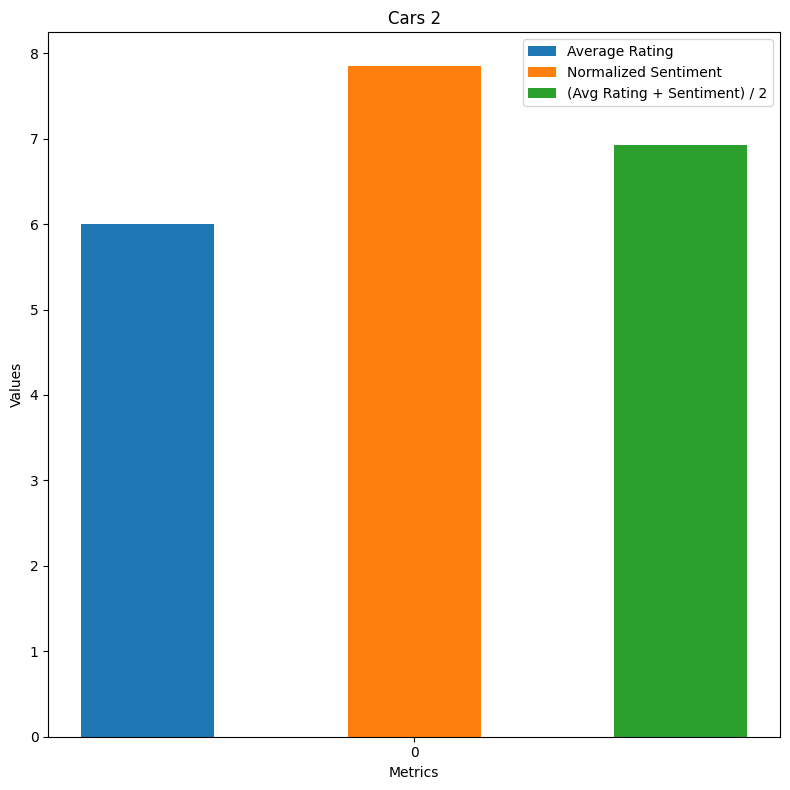

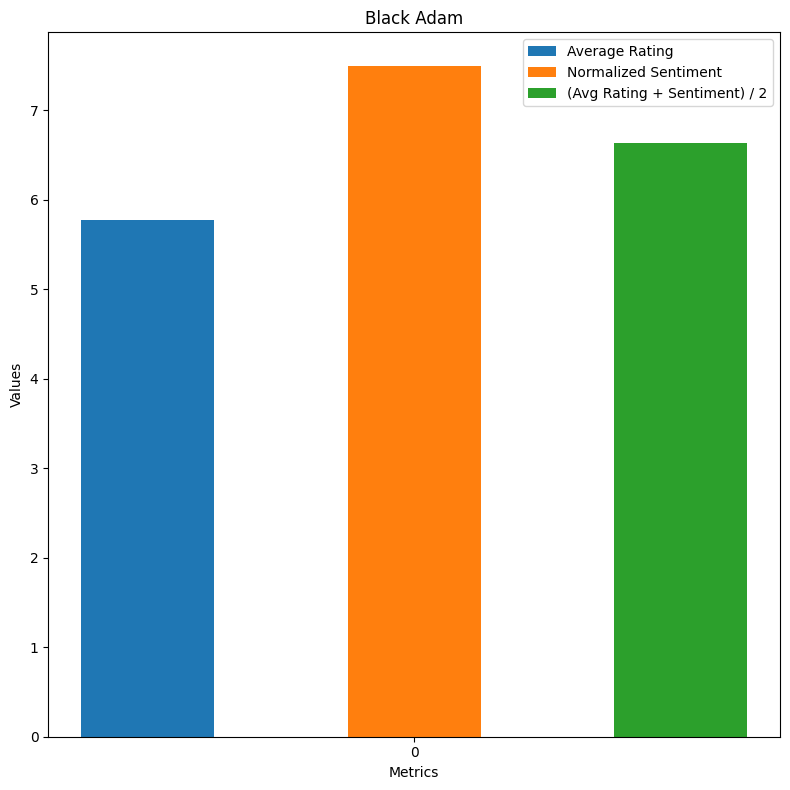

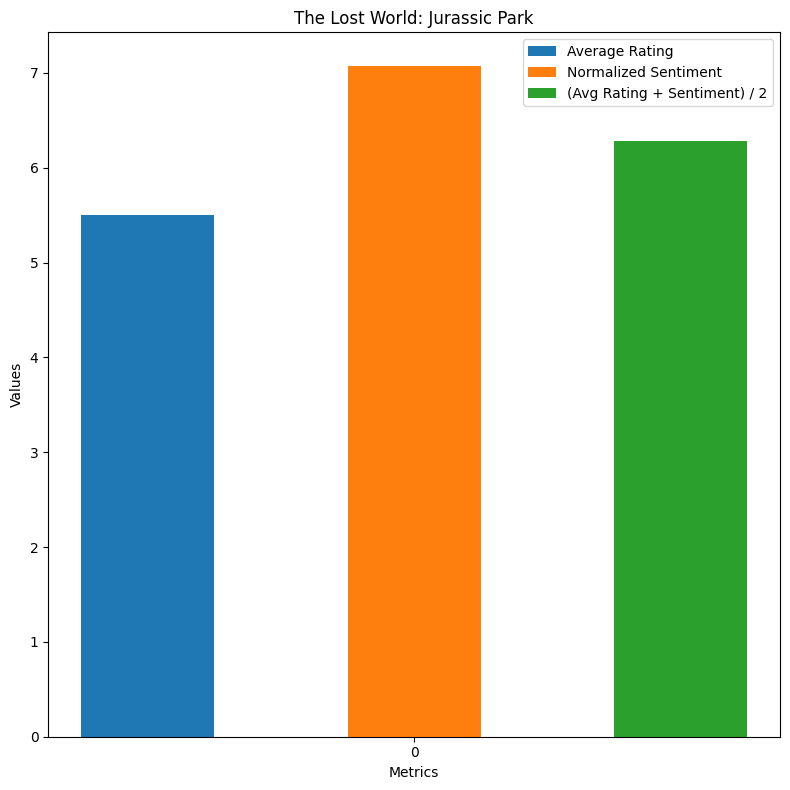

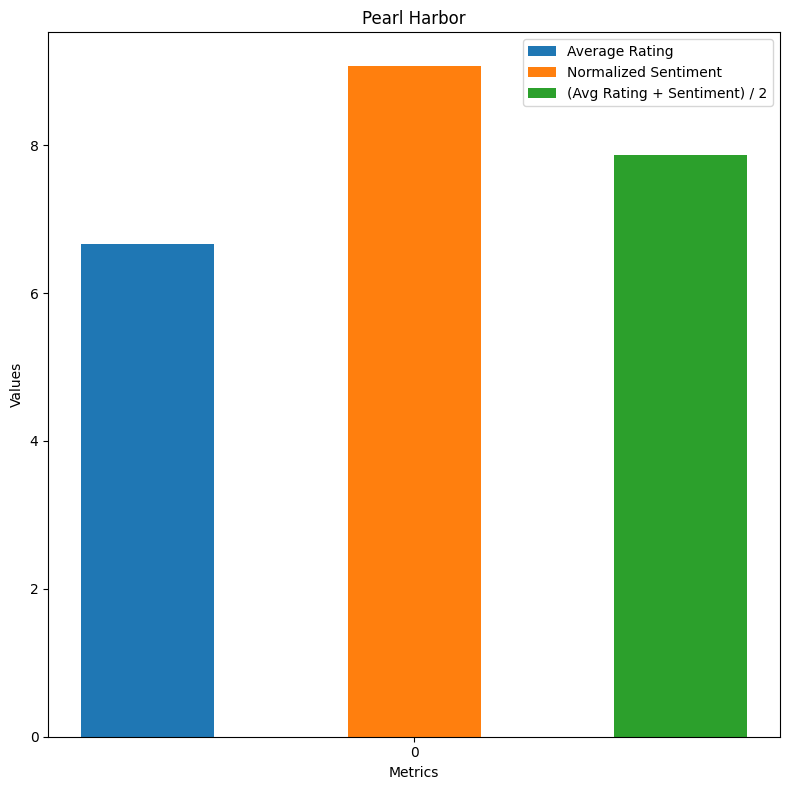

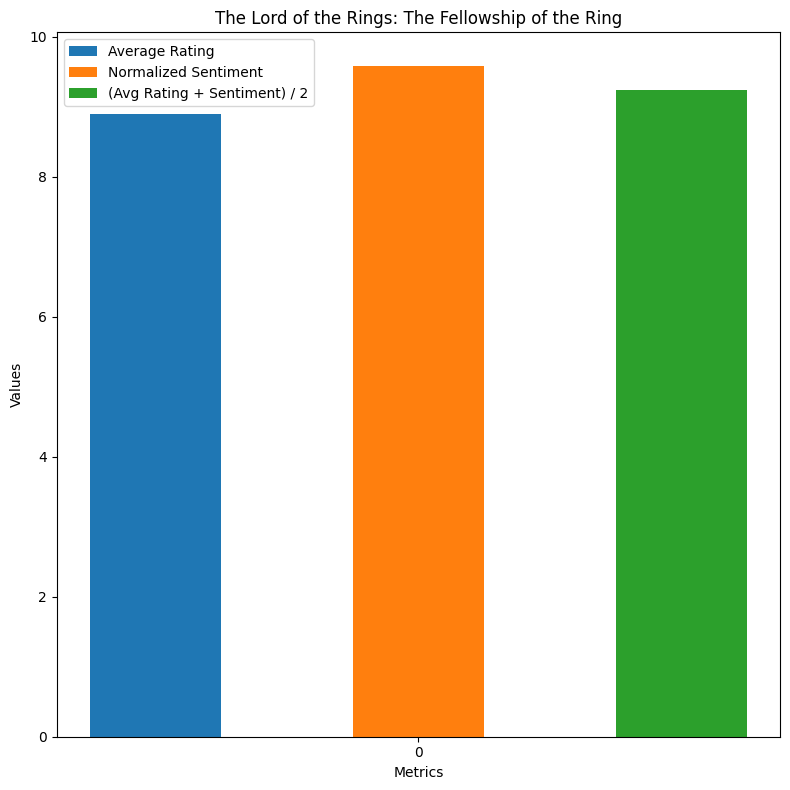

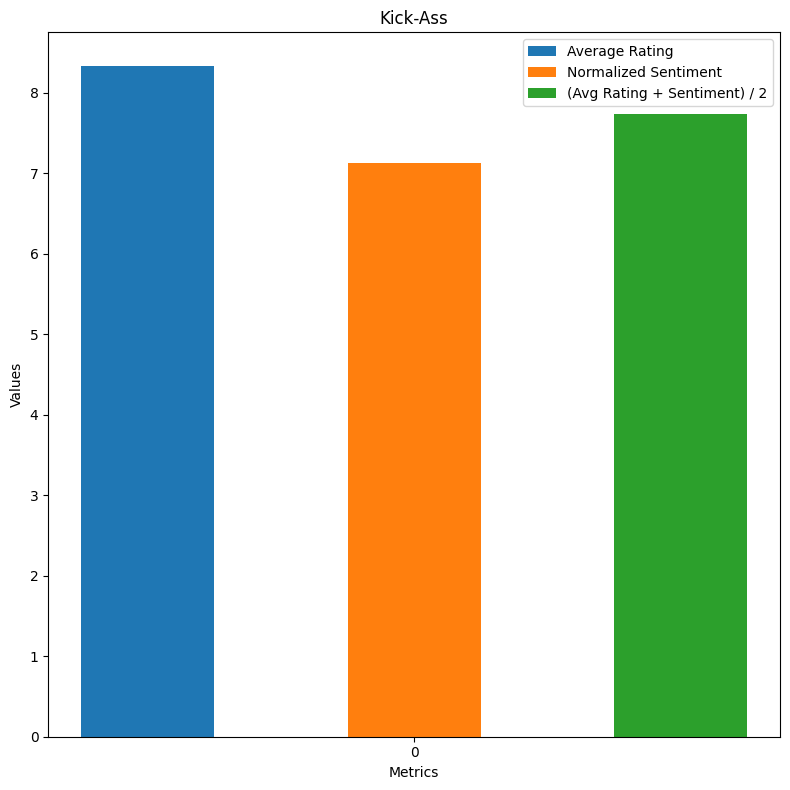

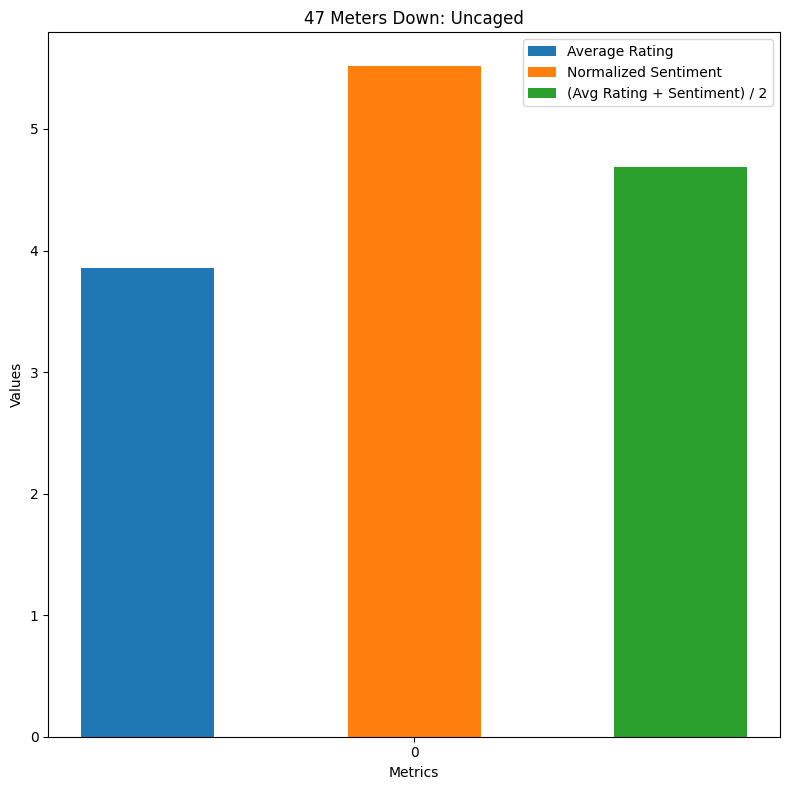

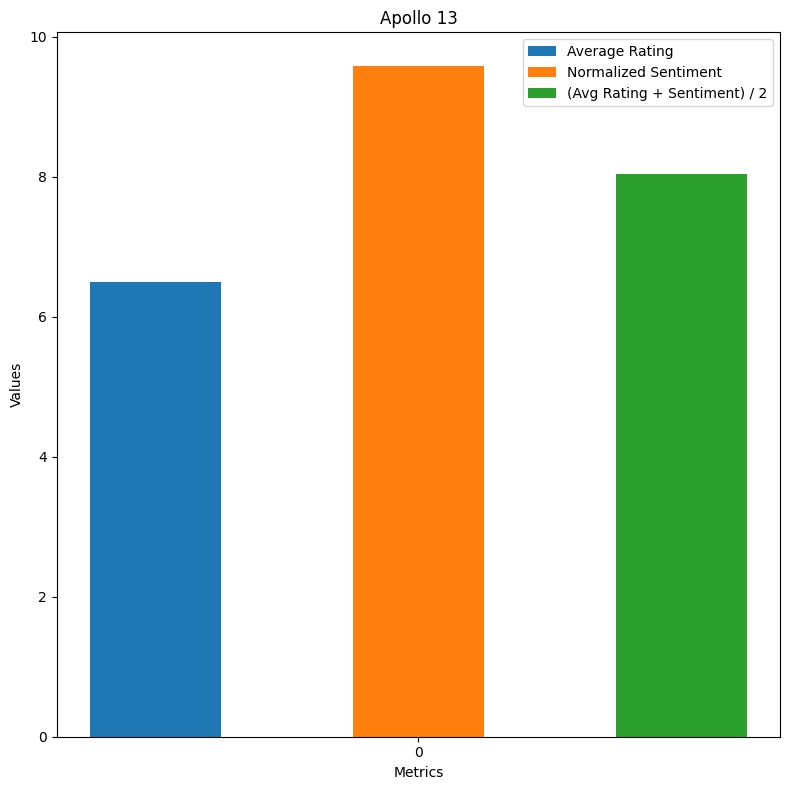

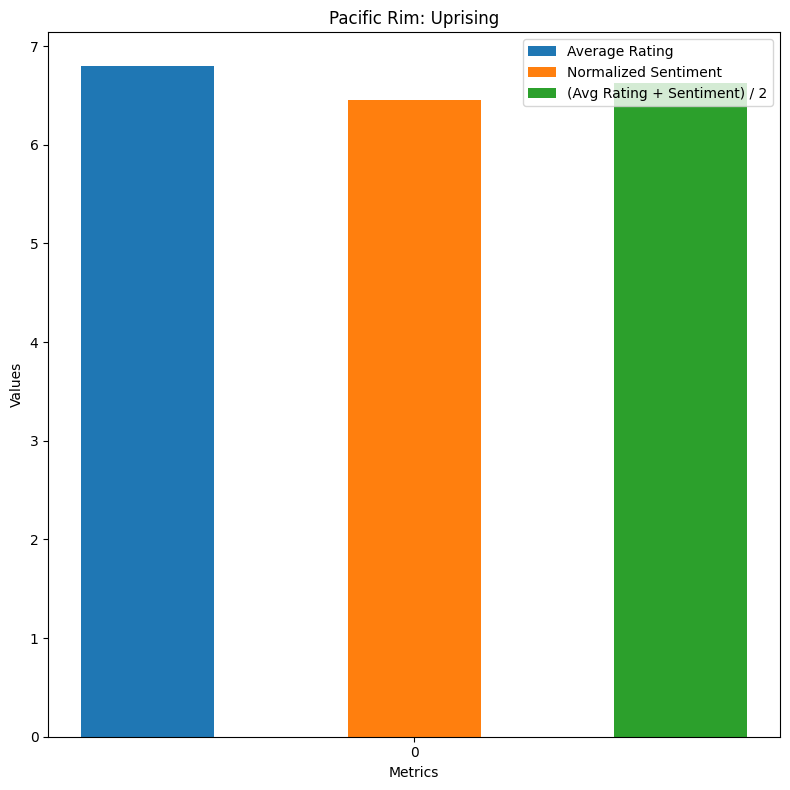

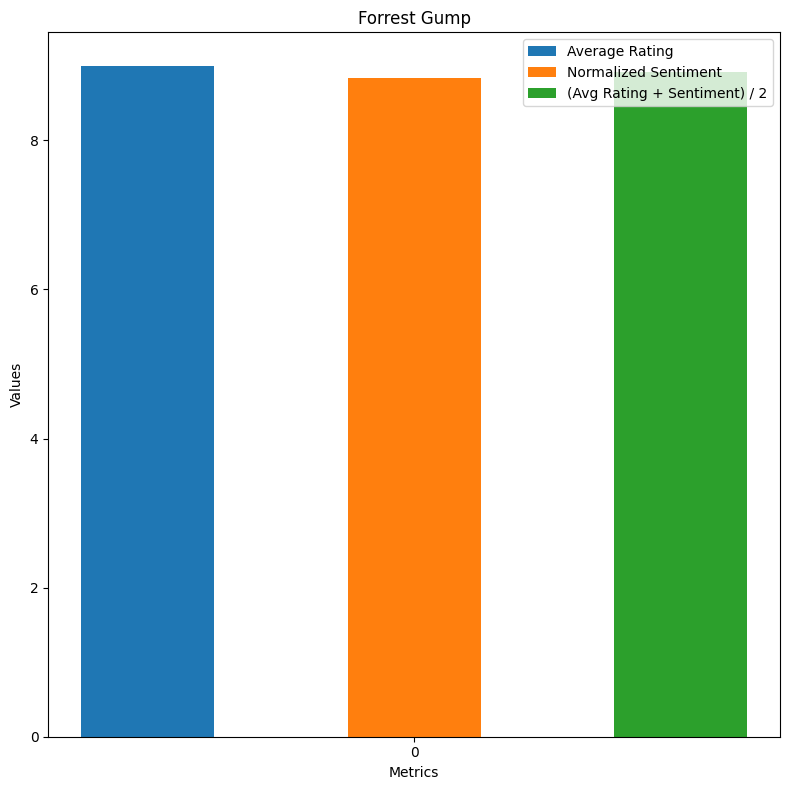

In [12]:
for movie, metrics in result.items():
    avg_rating = metrics['avg_rating']
    normalized_sentiment = metrics['normalized_sentiment']
    rating_norm_sentiment_divided = metrics['rating_norm_sentiment_divided']

    bar_spacing = 0.2
    bar_width = 0.1

    index = np.arange(1)

    fig, ax = plt.subplots(figsize=(8, 8))

    bar1 = ax.bar(index - bar_spacing, avg_rating, bar_width, label='Average Rating')
    bar2 = ax.bar(index, normalized_sentiment, bar_width, label='Normalized Sentiment')
    bar3 = ax.bar(index + bar_spacing, rating_norm_sentiment_divided, bar_width, label='(Avg Rating + Sentiment) / 2')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f'{movie}')
    ax.set_xticks(index)
    ax.legend()

    plt.tight_layout()
    plt.show()

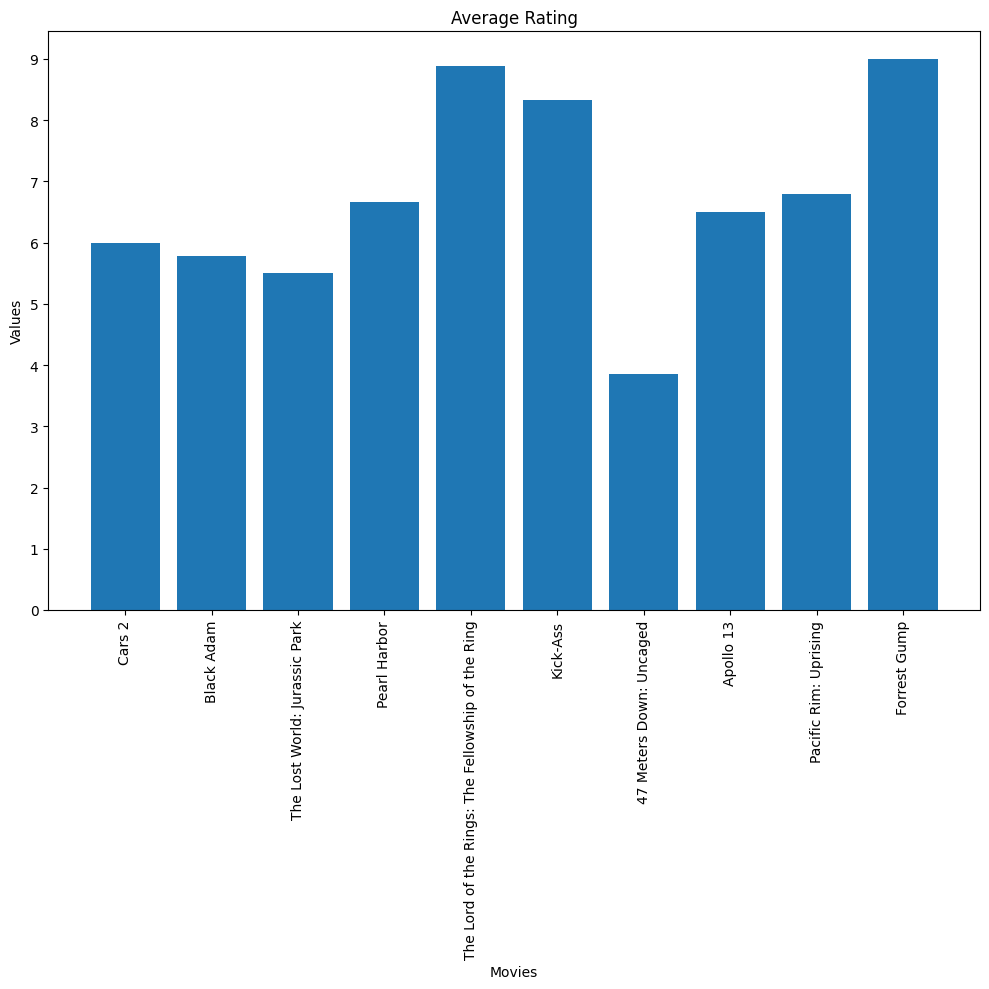

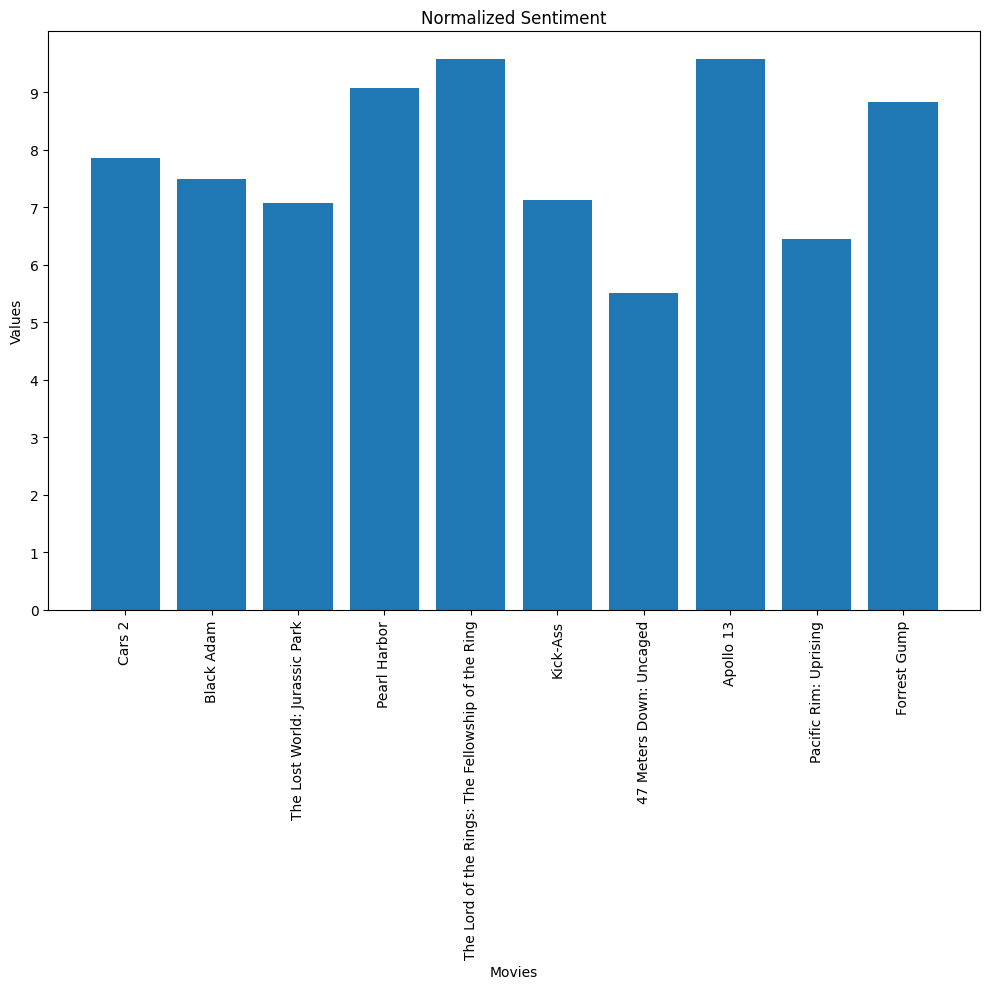

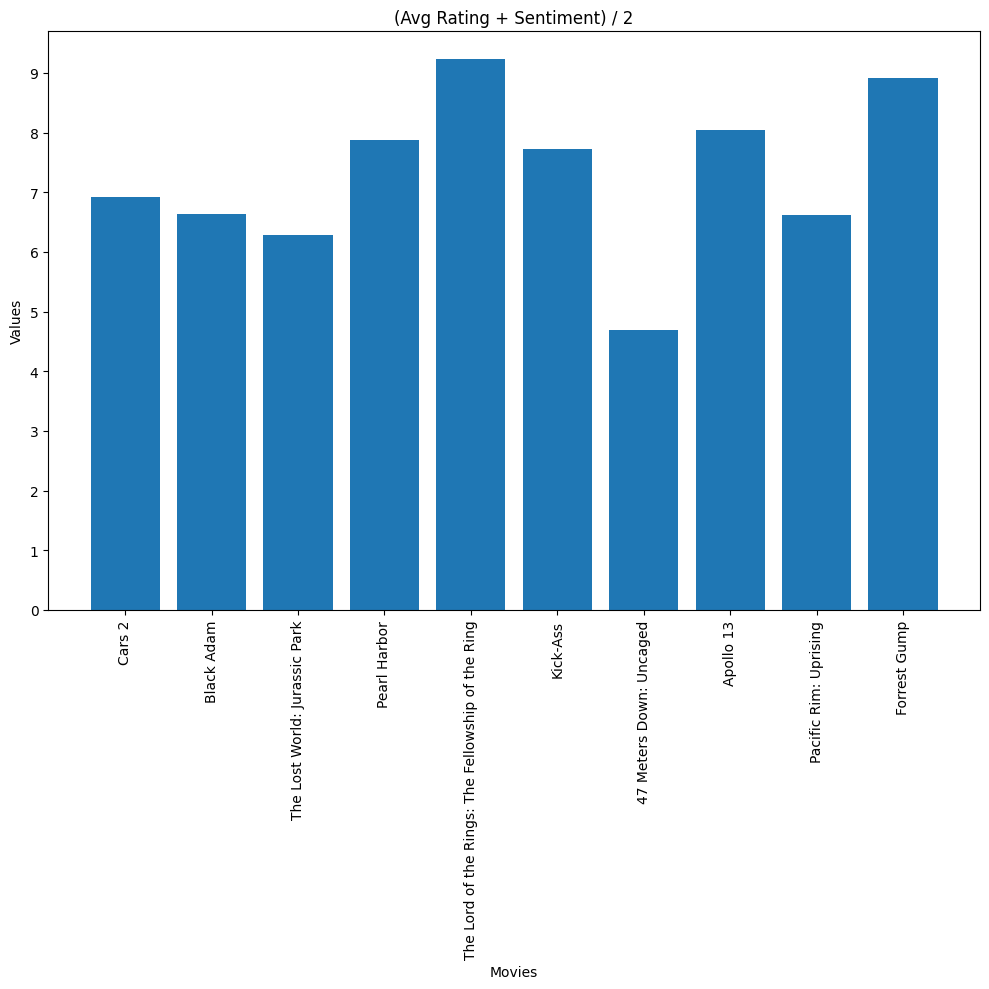

In [20]:
movies = list(result.keys())
avg_ratings = [metrics['avg_rating'] for metrics in result.values()]
normalized_sentiments = [metrics['normalized_sentiment'] for metrics in result.values()]
rating_norm_sentiments = [metrics['rating_norm_sentiment_divided'] for metrics in result.values()]

categories = [
    ("Average Rating", avg_ratings),
    ("Normalized Sentiment", normalized_sentiments),
    ("(Avg Rating + Sentiment) / 2", rating_norm_sentiments),
]

for index, (title, value) in enumerate(categories):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.bar(movies, value)
    ax.set_title(title)
    ax.set_ylabel('Values')
    ax.set_yticks(np.arange(10))
    ax.set_xticks(range(len(movies)))
    ax.set_xticklabels(movies, rotation=90)
    ax.set_xlabel('Movies')

    plt.tight_layout()
    plt.show()

[-1.8514, -1.722649999999999, -1.5740833333333333, -2.4050000000000002, -0.692055555555557, 1.2071666666666676, -1.6617142857142864, -3.0827500000000008, 0.3487999999999998, 0.1620000000000008]


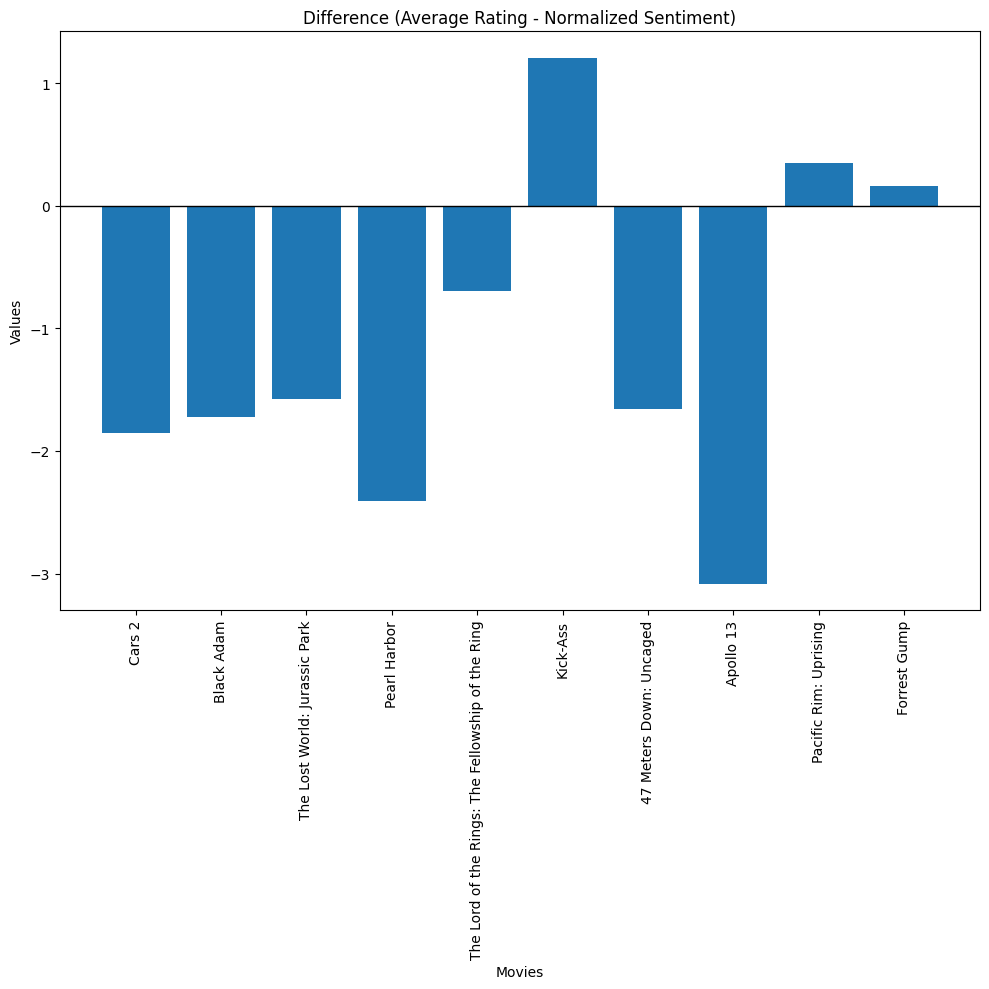

In [34]:
differences = [metrics["avg_rating"] - metrics["normalized_sentiment"] for metrics in result.values()]
print(differences)

categories.append(("Difference (Average Rating - Normalized Sentiment)", differences))

fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(movies, differences)
ax.set_title("Difference (Average Rating - Normalized Sentiment)")
ax.set_ylabel('Values')
ax.set_xticks(range(len(movies)))
ax.set_xticklabels(movies, rotation=90)
ax.set_xlabel('Movies')

ax.axhline(0, color='black', linewidth=1, linestyle='-')

plt.tight_layout()
plt.show()

### Interpretation of the values:

# Positive values -> The Average Rating is higher than the Normalized Sentiment. This could indicate 
# that the average rating is better than the sentiment or emotional reactions reflected in the reviews.
# The movie might have been rated as high quality, although opinions were more mixed or less positive.

# Negative values -> The Normalized Sentiment is higher than the Average Rating. This could mean
# that the moods or opinions in the reviews are more positive than the average ratings suggest. 
# The film may have been perceived more positively emotionally than the rating indicates.

In [158]:
def extract_keywords_of_a_reviews(review: str, top_n: int) -> List[str]:
    """
    Extract the top N keywords from a given review.

    Parameters
    ----------
    review : str
        The text of the review from which to extract keywords.
    top_n : int
        The number of top keywords to extract.

    Returns
    -------
    List[str]
        A list of the top N keywords extracted from the review.
    """

    raw_keywords = keybert.extract_keywords(review, keyphrase_ngram_range=(1, 2), top_n=top_n, stop_words="english")
    return [keyword[0] for keyword in raw_keywords]
    # print(f"Raw_keyboards: {raw_keywords}")

    # filtered_keywords = []
    # for keyword in raw_keywords:
    #     doc = nlp(keyword)
    #     if any(token.pos_ in ["NOUN", "ADJ", "VERB"] for token in doc):
    #         filtered_keywords.append((keyword))

    # print(f"Filtered_keywords: {filtered_keywords}")
    # return filtered_keywords[:top_n]

In [159]:
def analyze_sentiment_for_keywords(review: str, top_n: int) -> Dict[str, int]:
    """
    Analyze the sentiment for the top N keywords in a review.

    This function extracts the top N keywords from a review using a BERT-based
    aspect analysis method and then analyzes the sentiment of each keyword using
    the VADER sentiment analysis tool.

    Parameters
    ----------
    review : str
        The text of the review to analyze.
    top_n : int
        The number of top keywords to extract and analyze.

    Returns
    -------
    Dict[str, int]
        A dictionary where the keys are the extracted keywords and the values
        are the compound sentiment scores for each keyword.
    """
    # keywords = analyze_aspects_with_tfidf(review, top_n)
    keywords = extract_keywords_of_a_reviews(review, top_n)
    # print(f"Review: {review},\nkeywords: {keywords}")
    # print(f"\nKeywords: {keywords}")

    keyword_sentiment = {}

    for keyword in keywords:
        sentiment = analyzer.polarity_scores(keyword)
        # print(f"\nKeyword: {keyword}: sentiment: {sentiment}")
        keyword_sentiment[keyword] = sentiment["compound"]

    # print(f"\nKeyword_sentiment: {keyword_sentiment}")
    return keyword_sentiment

In [160]:
def rank_movies(movies_with_their_reviews: Dict[str, List[Dict[str, Any]]]) -> Dict[str, float]:
    """
    Ranks movies based on their reviews using sentiment analysis and ratings.
    Parameters

    ----------
    movies_with_their_reviews : Dict[str, List[Dict[str, Any]]]
        A dictionary where the keys are movie titles and the values are lists of dictionaries containing review data.
        Each review dictionary should have a "content" key with the review text and optionally a "rating" key with the review rating.

    Returns
    -------
    Dict[str, float]
        A dictionary where the keys are movie titles and the values are the calculated scores, sorted in descending order.
    """

    scores = {}

    for movie, reviews in movies_with_their_reviews.items():
        total_sentiment_score = 0
        total_keywords_sentiment = 0
        total_rating = 0

        for review_data in reviews:
            rating = review_data.get("rating", None)

            # print(f"Movie: {movie}, Rating: {rating}")

            if rating in (2, 9, None):
                continue

            # if rating is None:
            #     rating = 2.0

            # print(f"After check Rating - Movie: {movie}, Rating: {rating}")

            sentiment_scores = analyzer.polarity_scores(review_data["content"])
            sentiment_score = sentiment_scores["compound"]

            # keyword_sentiment = analyze_sentiment_for_keywords(review, top_n=5)
            sentiment = analyze_sentiment_for_keywords(review_data["content"], top_n=5)
            # print(f"Movie: {movie}, sentiment_keywords: {sentiment}")
            # print(sentiment)

            keyword_sentiment = sum(sentiment.values())
            total_keywords_sentiment += keyword_sentiment

            total_sentiment_score += sentiment_score
            total_rating += rating

        avg_sentiment = total_sentiment_score / len(reviews)
        avg_rating = total_rating / len(reviews)
        avg_keywords_sentiment = total_keywords_sentiment / len(reviews)

        score = (0.5 * avg_sentiment) + (0.3 * avg_rating) + (0.2 * avg_keywords_sentiment)

        scores[movie] = score
        print(
            f"Movie: {movie}, score: {score:.2f}, avg_sentiment: {avg_sentiment}, avg_rating: {avg_rating}, avg_keywords_sentiment: {avg_keywords_sentiment}"
        )
        
    ranked_movies = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
    # print(ranked_movies)

    for rank, (movie, score) in enumerate(ranked_movies.items(), start=1):
        print(f"Rank: {rank}, movie: {movie}, score: {score:.2f}")

    return ranked_movies

In [161]:
ranked_movies = rank_movies(filtered_reviews)

Movie: Cars 2, score: 2.16, avg_sentiment: 0.57028, avg_rating: 6.0, avg_keywords_sentiment: 0.3554
Movie: Black Adam, score: 1.67, avg_sentiment: 0.4120999999999999, avg_rating: 4.729166666666667, avg_keywords_sentiment: 0.22261250000000002
Movie: The Lost World: Jurassic Park, score: 1.84, avg_sentiment: 0.41481666666666667, avg_rating: 5.5, avg_keywords_sentiment: -0.09915
Movie: Pearl Harbor, score: 1.34, avg_sentiment: 0.4827000000000001, avg_rating: 3.6666666666666665, avg_keywords_sentiment: 0.0
Movie: The Lord of the Rings: The Fellowship of the Ring, score: 2.81, avg_sentiment: 0.822388888888889, avg_rating: 7.888888888888889, avg_keywords_sentiment: 0.13942222222222223
Movie: Kick-Ass, score: 1.20, avg_sentiment: 0.06995, avg_rating: 4.0, avg_keywords_sentiment: -0.17385
Movie: 47 Meters Down: Uncaged, score: 1.17, avg_sentiment: 0.19855714285714288, avg_rating: 3.5714285714285716, avg_keywords_sentiment: -0.00478571428571429
Movie: Apollo 13, score: 2.41, avg_sentiment: 0.91

In [166]:
sorted_movies = dict(sorted(result.items(), key=lambda x: x[1]['rating_norm_sentiment_divided'], reverse=True))
for index, (movie, _) in enumerate(sorted_movies.items(), start=1):
    print(f"Rank: {index}, movie: {movie}")

Rank: 1, movie: The Lord of the Rings: The Fellowship of the Ring
Rank: 2, movie: Forrest Gump
Rank: 3, movie: Apollo 13
Rank: 4, movie: Pearl Harbor
Rank: 5, movie: Kick-Ass
Rank: 6, movie: Cars 2
Rank: 7, movie: Black Adam
Rank: 8, movie: Pacific Rim: Uprising
Rank: 9, movie: The Lost World: Jurassic Park
Rank: 10, movie: 47 Meters Down: Uncaged
